This analysis focuses on the Entry Level Luxury Performance Sedans forum from the website Edmunds.com found [here](https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p1). We focused on the oldest 4-5k posts, starting on page 1. 

#### Installing the chromedriver / selenium

In [ ]:
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium #may not need to run this 

!apt-get -q update # to update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver

Grabbing discussion forums from Edmonds


In [ ]:
import pandas as pd
import sys
sys.path.insert(0,r"C:\Users\india\Downloads\chromedriver.exe")
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome('chromedriver', options=chrome_options)

comments = pd.DataFrame(columns = ['Date','user_id','comments']) #creating dataframe to store date, userid, and comments
page = 1 #starting at first page
while len(comments) <= 4500: #we want 4000-5000 posts
    website = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p" + str(page)
    driver.get(website)
    com_id = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]") #grabbing comment id number 
    comment_ids = [] #creating empty list to store username
    for i in com_id:
        comment_ids.append(i.get_attribute('id')) #appending to list  
    for x in comment_ids:
        #Extract dates from for each user on a page
        user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')

        #Extract user ids from each user on a page
        userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text

        #Extract Message for each user on a page
        user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
        comment = user_message.text
                                   
        #Adding date, userid and comment for each user in a dataframe    
        comments.loc[len(comments)] = [date,userid,comment]
    page = page + 1

#ignores the first post.. just included "response" comments which are actual comments 

In [7]:
comments.head()

,Date,user_id,comments
0,"March 24, 2002 10:54PM",merc1,I personally think that with a few tweaks the ...
1,"March 25, 2002 12:06AM",fredvh,I am debating a new purchase and these two are...
2,"March 25, 2002 10:02AM",blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,"March 25, 2002 4:04PM",hungrywhale,And no manual tranny. That may not matter to y...
4,"March 25, 2002 5:44PM",riez,One beauty of BMW 3 Series is that there are s...


#Counting the frequencies of all words

We are interested in learning the associations of car brands. Many of the forum posts mention the car's make/model instead of the brand. We created a dataset consisting of brands and their associated models. We will use to convert any mention of a model to its respective brand. 

In [ ]:
 uploaded2 = files.upload()

Saving CLEAN - car models and brands.csv to CLEAN - car models and brands.csv


In [ ]:
models_brands = pd.read_csv(io.BytesIO(uploaded2['CLEAN - car models and brands.csv']),header=None)
models_brands.rename(columns = {0:'brand',1:'model'}, inplace = True) 
models_brands

,brand,model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx
...,...,...
543,volvo,xc90
544,volvo,s60
545,volvo,s80
546,volvo,v60


Several of the models consist of 2 or more words. The code below identifies such models. I then created a list of the first words within the model names so we could include these 2 or more brand names within our word frequency counter. 

In [ ]:
#how many models consist of 2 words? more than that? 
models_brands['m_words'] = [len(x.split()) for x in models_brands['model'].tolist()]
m_counts = models_brands[models_brands['m_words'] > 1]

m_counts

,brand,model,m_words
41,buick,park avenue,2
42,buick,la crosse,2
52,chevrolet,grand blazer,2
115,chrysler,town and country,3
116,chrysler,chrysler 300,2
117,chrysler,chrysler 200,2
266,lexus,is 200,2
267,lexus,is 300,2
268,lexus,is 220,2
269,lexus,is 250,2


In [ ]:
#creating list of first words from brands with more than 1 word
first_words = []
for i in m_counts['model']:
  i = i.split()
  if i[0] != 'chrysler': #drop chrysler from it as will already be picked up
    first_words.append(i[0])

Calculating frequency of words for full list of comments: 

In [ ]:
import nltk
import re
nltk.download('stopwords')

wordcounter = pd.DataFrame(columns = ['Word','Count','Brand']) #creating dataframe to store words and their frequency counts

stop_words = set(stopwords.words('english')) 

df['comments'] = df['comments'].astype(str) #ensuring it's a string

for com in df['comments']: #for each comment 
  com = re.sub(r'[^\w\s]', '', com) #removing punctuation 
  words = com.lower().split()
  words = [word for word in words if word not in stop_words] #removing stopwords
  already_here = [] #list that will contain words already seen in this comment... "restarted" for each comment 
  
  for i in range(len(words)): #for each word in the comment
    w = words[i]
    b = False #to keep record if word is a brand or not

    if w in models_brands['model'].tolist(): #if the word is a brand of car, change it to the appropriate car model
      w = models_brands.loc[models_brands['model'] == w, 'brand'].iloc[0] #get brand associated with this model
      b = True

    if w in first_words and i <= (len(words)-2): #if word is a match for the first word in list of models that are 2 words
      second_word = words[i+1]
      two_word_model = w+' '+second_word #combining with next word 

      if two_word_model == 'town and': #town and country is the only 3 letter word 
        w = 'chrysler'
        b = True

      elif two_word_model in m_counts['model'].tolist(): #if the model is a two-word model
        print(two_word_model)
        w = models_brands['brand'][models_brands['model'] == two_word_model].iloc[0] #get brand associated with this model
        b = True

    if w not in already_here: #if word is not seen yet in comment

      if w in wordcounter['Word'].tolist(): #if word already seen in another comment 
        w_index = wordcounter.index[wordcounter['Word'] == w] #find index of this word in dataframe
        wordcounter.loc[w_index,'Count'] += 1 #increment it's count 
        if b == True: #if the word is a brand name, update brand column
          wordcounter.loc[w_index,'Brand'] = 'yes'
        else:
          wordcounter.loc[w_index,'Brand'] = 'no'

      else: #if word is not already in df, add as new word
        if b == True:
          new_row = {'Word':w, 'Count':1,'Brand':'yes'} #if it's a brand and not already in dataset
        else:
          new_row = {'Word':w, 'Count':1,'Brand':'no'}
        wordcounter = wordcounter.append(new_row,ignore_index=True) #add row to dataframe
        
      already_here.append(w) #since we are seeing this word in this comment, add it to this list to avoid duplicating 


Looking into our wordcounter file:

In [ ]:
wordcounter.sort_values(by='Count',ascending=False, inplace=True)
wordcounter

,Word,Count,Brand
57,car,1817,no
86,bmw,1220,no
127,cars,1171,no
69,like,1151,no
141,one,1033,no
...,...,...,...
10951,atmospheric,1,no
10952,instrumentation,1,no
10954,wheelspin,1,no
10955,upshiftss,1,no


Looks like the brand column was not updated properly for some of the brands. The following script does this manually

In [ ]:
brands2update = ['bmw','acura','saab','hyundai','cadillac','mazda','chrysler','porsche','jaguar','ferrari']

for w in counters['Word'].tolist():
  if w in brands2update:
    counters.loc[counters['Word']==w,'Brand'] = 'yes'

#dataset had both acura and acuras.. manually combining them 

c_acuras = counters['Count'].loc[counters['Word']=='acuras'].values
c_acura = counters['Count'].loc[counters['Word']=='acura'].values
total = c_acura + c_acuras
counters.loc[counters['Word']=='acura','Count'] = total


Brands mentioned within the forum posts and their frequencies: 

In [ ]:
brands = pd.DataFrame(counters[counters['Brand']=='yes'])
brands

,Word,Count,Brand
1,bmw,1220,yes
25,acura,564,yes
38,lexus,407,yes
43,honda,388,yes
55,infiniti,353,yes
77,nissan,291,yes
82,toyota,285,yes
165,subaru,192,yes
212,mercedes benz,156,yes
218,volkswagen,154,yes


The 5 most commonly mentioned car attributes and their frequencies:

In [ ]:
attr = ['performance','luxury','engine','price','power']
attributes = counters[counters['Word'].isin(attr)]
attributes

,Word,Count,Brand
17,performance,602,no
39,luxury,402,no
42,engine,396,no
45,price,374,no
59,power,345,no


Getting frequency counts of aspirational words: 

We identified our aspirational words by looking through the most frequent words that also conveyed a notion of desire. We found the following aspirational words were popular within the comments: 'would','like','looking','want', and 'buy'. 

These words are indicative of interest. However, we are also concerned with action. To capture this, we identified bi-grams in which the first word was one of the aspirational words listed above and the second word indicated action ('to',and 'for'). We then found the frequencies of these words. 

It's important to note that 'want' and 'want to' overlap in their count of the word 'want'. We wanted to capture both of these phrases but as we are more concerned with action terms, we will place more weight on the bi-grams within our analysis. 

In [ ]:
asp_first_words = ["would", "like","want","buy","looking","love"]
asp_second_words = ["to","for","want"]
comments = df.copy(deep=True) #renaming comments dataframe so it makes more sense 

In [ ]:
import nltk
import re

#grabbing frequency counts of our aspirational words

asp_counts = pd.DataFrame(columns = ['Word','Count']) #creating dataframe to store words and their frequency counts

comments['comments'] = comments['comments'].astype(str) #ensuring it's a string


#don't remove stopwords, we want words like "to" or "for"
for com in comments['comments']: #for each comment

  com = re.sub(r'[^\w\s]', '', com) #removing punctuation 

  words = list(com.lower().split()) #create list of words

  #for counting frequency of aspirational words
  asp_already_here = [] #list that will contain words already seen in this comment... "restarted" for each comment

  for i in range(len(words)): #for each word in the comment
    w = words[i]

     #finding frequency counts 

    if w in asp_first_words and i <= (len(words)-2): #if word is an aspirational word
      second_word = words[i+1]

      if second_word in asp_second_words: #if its a two word aspirational word
        w = w+' '+second_word
    
    #if word is not seen yet in comment and w is an aspirational word and it's not a brand (already calculated those frequencies)

      if w not in asp_already_here: #if the aspirational word has not been seen yet in this comment 

        if w in asp_counts['Word'].tolist(): #if word already seen in another comment 
          w_index = asp_counts.index[asp_counts['Word'] == w] #find index of this word in dataframe
          asp_counts.loc[w_index,'Count'] += 1 #increment it's count 

        else: #if word is not already in df, add as new word
          new_row = {'Word':w, 'Count':1}
          asp_counts = asp_counts.append(new_row,ignore_index=True) #add row to dataframe
        
        asp_already_here.append(w) #since we are seeing this word in this comment, add it to list of words seen in this comment 
 

In [8]:
asp_counts

,Word,Count
0,would,923
1,like,1093
2,looking,187
3,want,285
4,buy,386
5,want to,243
6,looking to,20
7,love,186
8,looking for,56
9,would want,23


## Now calculating lift values: 

Calculating lift is a high level approach that seeks to capture the essential associations within the data. Lift provides a score that indicates how likely it is for two words A and B to be mentioned together, given they are mentioned at all. 

A lift value greater than 1 indicates that the association between words A and B is stronger than random chance. A lift value equal to 1 merely indicates that these words are only randomly associated. A lift value less than 1 indicates that any co-mention of these two words is less likely to occur than random chance. A lift value less than 1 does not have a practical meaning but rather indicates that two words are strongly not associated with each other. 



Comparing the lift values between the top 10 brands: 

In [ ]:
brands = brands[0:10] #grabbing top 10 brands
clean_carbrands = models_brands.copy(deep=True)

#creates blank matrix
def create_matrix(row,column):
  m = [[0] * len(column)] * len(row)
  df = pd.DataFrame(m,columns = column, index = row) 
  return df

In [ ]:
#defining a matrix to store lifts for brands
brand_list = brands['Word'].tolist()
brand_lifts = create_matrix(brand_list,brand_list)

Creating a list of lists of brands that occur together within one comment

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

comments['comments'] = comments['comments'].astype(str) #ensuring it's a string

all_comments = [] #list of lists.. each list containing lists of brands in one comment

for com in comments['comments']: #for each comment
  this_comment = [] #list storing all brands that appeared in this comment 
  com = re.sub(r'[^\w\s]', '', com) #removing punctuation 
  
  words = com.lower().split() #making words lower case and splitting on spaces 
  words = [word for word in words if word not in stop_words] #removing stopwords
  words = model_to_brand(words) #changing all car models to brands

  for i in range(len(words)): #for each word in the comment
    w = words[i] #w is word at the given index i 

    #changing models to brands 

    if w in clean_carbrands['model'].tolist(): #if the word is a brand of car, change it to the appropriate car model
      w = clean_carbrands.loc[clean_carbrands['model'] == w, 'brand'].iloc[0] #get brand associated with this model
    
    if w in first_words and i <= (len(words)-2): #if word is a match for the first word in list of models that are 2 words
      second_word = words[i+1]
      two_word_model = w+' '+second_word #combining with next word 

      if two_word_model == 'town and': #town and country is the only 3 letter word 
        w = 'chrysler'

      elif two_word_model in m_counts['model'].tolist(): #if the model is a two-word model
        w = clean_carbrands['brand'][clean_carbrands['model'] == two_word_model].iloc[0] #get brand associated with this model

    if w == 'acuras': #need to change it to acura
      w = 'acura'

    if w in brands['Word'].tolist(): #if the word is a brand
      if w not in this_comment: #if brand is not already seen in this comment
        this_comment.append(w) #add brand to list
    
  all_comments.append(this_comment) #add list to list of brands in all comments 

The matrix now contains counts of number of times each brand occured with each other. The below code calculates the lift values for the brands

In [ ]:
brand_lifts = brand_lifts.astype(float)

for sublist in all_comments: #for each list of brands that appeared within a single comment
    for i in range(len(sublist)): 
      for j in range(len(sublist)): 
        row = sublist[i]
        column = sublist[j]
        brand_lifts.at[row,column] +=1

brandlifts2 = brand_lifts.copy(deep=True)

In [ ]:
N = len(comments)

for sublist in all_comments:
  for i in range(len(sublist)): #i = 0,1,2,3,4
    for j in range(len(sublist)): #j = 0,1,2,3,4 j = 1,2,3,4
      row = sublist[i] #brand1
      column = sublist[j] #brand2
      brand1count = brands['Count'][brands['Word'] == row].iloc[0]
      brand2count = brands['Count'][brands['Word'] == column].iloc[0]
      totalcount = brand1count*brand2count
      #print(row,brand1count,column,brand2count,totalcount)
      current_value = float(brand_lifts.loc[row,column]*N)
      lift = float(current_value / totalcount)
      brandlifts2.at[row,column] = lift

In [12]:
brand_lifts

,bmw,acura,lexus,honda,infiniti,nissan,toyota,subaru,mercedes benz,volkswagen
Brand,,,,,,,,,,
bmw,3.729508,1.481223,1.896826,1.268802,2.017949,1.268802,1.491803,1.223745,1.960383,1.767884
acura,1.481223,7.766995,2.556982,2.411896,2.742451,2.051498,1.755008,1.806756,1.965130,1.623952
lexus,1.896826,2.556982,11.179361,1.383014,3.483654,1.844018,2.941937,1.280968,3.941441,2.032611
honda,1.268802,2.411896,1.383014,11.726804,1.428478,3.989531,4.155815,1.404773,1.728952,2.360590
infiniti,2.017949,2.742451,3.483654,1.428478,12.889518,2.524751,1.221112,1.812589,3.057129,2.008756
nissan,1.268802,2.051498,1.844018,3.989531,2.524751,15.635739,3.785495,1.465851,1.603666,2.944392
toyota,1.491803,1.755008,2.941937,4.155815,1.221112,3.785495,15.964912,1.413560,2.353801,2.280702
subaru,1.223745,1.806756,1.280968,1.404773,1.812589,1.465851,1.413560,23.697917,0.759549,2.308239
mercedes benz,1.960383,1.965130,3.941441,1.728952,3.057129,1.603666,2.353801,0.759549,29.166667,4.166667


Honda and Toyota share a high lift value of 4.15. As these brands are similar in models, quality, and affordability, this value suggests that users may be debating between these 2 brands while purchasing. 

A notable association is between Mercedes and Volkswagon. Mercedes is a luxury brand while Volkswagen is not, indicating that consumers may be comparing these brands in quality while offering Volkswagen as an affordable option. 

Interestingly, the only lift value less than 1 is between Subaru and Mercedes Benz. Subaru is typically not considered a luxury brand while Mercedes is. This lift value indicates that Subaru and Mercedes are not often compared in the sedan market. From our personal experience, Subaru sedans are commonly considered rugged outdoors cars and often have a target audience of consumers who prefer to customize their cars. In contrast, Mercedes tend to have a posh association and target an audience with a preference for luxury cars.

In [ ]:
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

lift_adj = 1/brand_lift_mds
lift_adj = lift_adj.fillna(0)

mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=1, max_iter=3000)
result = mds.fit(lift_adj)
pos = result.embedding_
X = pos[:,0]
Y = pos[:,1]

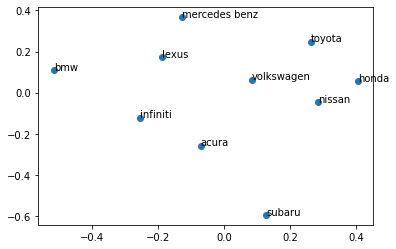

In [ ]:
plt.scatter(X,Y)
for i, txt in enumerate(lift_adj.index):
    plt.annotate(txt, (X[i], Y[i]))
plt.show()

The above MDS map aids us in visualizing the lift values between brands.

Based on it, there are several insights that we can offer brand managers. 

Let's first take a closer look at the relationship between Mercedes Benz and Lexus. Both of these brands are considered luxury brands and offer a variety of sedan models. The association between Mercedes Benz and Lexus is fairly high, at a value of 3.9, indicating that attributes and performance of their models are comparable. This illuminates that these brands may be considered close substitutes. However, these cars to differ in their country of make/origin. Lexus is from Japan while Mercedes is a German brand. Thus, it would be beneficial for brand managers to target their marketing using specific origin-based terms (for example: 'German Engineering') to differentiate their models. This will aid brands in retaining a loyal customer base on the basis of their differences and to stand out in contrast to the other brand.

Secondly, the closest association that we see is between Honda and Nissan.These brand's customers are most likely to be debating between each other. Brand managers both at Nissan and Honda can use this information to focus on the other as its competitor to find ways to differentiate itself from the other, specifically within the sedan market. 

Additionally, you can see that there is a small cluster with Toyota, Honda, Nissan, and Volkswagen. This makes sense as all of these brands are considered similar and none of them are luxury brands. They may have a high level of association between them as they could be reccommended as a list of luxury brand sedan alternatives. This information can be useful for the marketing departments of their brands to adjust their target audience to consumers looking for luxury brand sedan alternatives.  


The following scripts calculate lift for the top 5 attributes and the top 5 brands.

In [ ]:
brands2 = brands[0:5]
brands2
brands2list = brands2['Word'].tolist() #creating list of brands 
attr2list = attributes['Word'].tolist() #creating list of attributes

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

comments['comments'] = comments['comments'].astype(str) #ensuring it's a string

all_attr_comments = [] #list of lists.. each list of attr and brands in one comment 

for com in comments['comments']: #for each comment
  this_attr_comment = [] #list storing all attr that appeared in this comment 
  com = re.sub(r'[^\w\s]', '', com) #removing punctuation 
  words = com.lower().split()
  words = [word for word in words if word not in stop_words] #removing stopwords
  

  for i in range(len(words)): #for each word in the comment
    w = words[i]

    #changing models to brands 

    if w in clean_carbrands['model'].tolist(): #if the word is a brand of car, change it to the appropriate car model
      w = clean_carbrands.loc[clean_carbrands['model'] == w, 'brand'].iloc[0] #get brand associated with this model
    
    if w in first_words and i <= (len(words)-2): #if word is a match for the first word in list of models that are 2 words
      second_word = words[i+1]
      two_word_model = w+' '+second_word #combining with next word 

      if two_word_model == 'town and': #town and country is the only 3 letter word 
        w = 'chrysler'

      elif two_word_model in m_counts['model'].tolist(): #if the model is a two-word model
        w = clean_carbrands['brand'][clean_carbrands['model'] == two_word_model].iloc[0] #get brand associated with this model

    if w == 'acuras': #need to change it to acura
      w = 'acura'
    
    if w in brands2list or w in attr2list: #if the word is a brand
      if w not in this_attr_comment: #if brand is not already seen in this comment
        this_attr_comment.append(w) #add brand to list
    
  all_attr_comments.append(this_attr_comment) #add list to list of brands in all comments 

In [ ]:
#defining a matrix to store lifts
attr_lifts = create_matrix(brands2list,attr2list)

In [ ]:

attr_liftstest = attr_lifts.astype(float) #Need this column cast as a float

for sublist in all_attr_comments: #for each list of brands that appeared within a single comment
    for i in range(len(sublist)): 
      for j in range(len(sublist)): 
        row = sublist[i]
        column = sublist[j]
        if row in brands2list and column in attr2list:
          attr_liftstest.at[row,column] +=1
#now matrix contains counts of number of times each brand occured with each other 

attr_lifts = attr_liftstest.copy(deep=True)

In [ ]:
N = len(comments)

for sublist in all_attr_comments:
  for i in range(len(sublist)): #i = 0,1,2,3,4
    for j in range(len(sublist)): #j = 0,1,2,3,4 j = 1,2,3,4
      if sublist[i] in brands2list and sublist[j] in attr2list: #if first word is a brand and second word is an attrbute 
        row = sublist[i] #brand
        column = sublist[j] #attribute
        brand1count = brands2['Count'][brands2['Word'] == row].iloc[0] #number of total times brand occurs in comments
        attr2count = attr['Count'][attr['Word'] == column].iloc[0]  #number of total times attribute occurs in comments

        totalcount = brand1count*attr2count #multiply #A*#B
  
        current_value = float(attr_lifts.loc[row,column]*N) #GRABS total occurences of both A and B * N
        lift = float(current_value / totalcount)
        attr_lifts.at[row,column] = lift

In [15]:
attr_lifts

,performance,luxury,engine,price,power
Brand,,,,,
bmw,1.517823,1.308111,1.459782,1.455904,1.578285
acura,1.447303,1.846265,1.466796,1.574648,1.636859
lexus,1.615622,2.085702,1.383305,1.644024,1.296158
honda,1.480460,1.750269,1.480657,1.881305,1.733528
infiniti,1.563015,1.635237,1.399619,1.654270,1.382354


The highest lift value found within the table is 2.08, between luxury and Lexus. It is interesting that out of the three luxury brands listed (BMW, Lexus, and Infiniti), Lexus has the greatest association with luxury. 

The lowest list value is between Lexus and power, indicating that customers associate other brands with having more power. This may reveal that the target audience for Lexus cars is focused on a consumer base that values luxury as opposed to power. As sports cars and luxury cars appeal to different consumer bases, Lexus can build upon the strength of their association with luxury, as opposed to power, by focusing their marketing to highlight the elegant appeal. 

BMW appears in the middle of the pack for most attributes. However, it has fairly low lift values in the luxury and price department. Since it appears that BMW seems to lack in luxury and is overpriced, product managers should revise BMW's approach to luxury. Moreover, the marketing and advertising teams for BMW shoudl target their strategy to emphasize the brand's elegance and comfortable features.

Honda's strength is reliability. They have the highest lift values for price, power, and engine! Honda has a lower association with both performance and luxury. It may be being mentioned in the comments as comparison point with luxury cars for these attributes.
 
Infiniti, according to these lift values, appears to be an average/below average car compared to the other luxury brands. 


Calculating lift for aspirational words and brands

In [ ]:
asp_first_words = ["would", "like","want","buy","looking","love"]
asp_second_words = ["to","for","want"]

In [ ]:
import nltk
import re

comments['comments'] = comments['comments'].astype(str) #ensuring it's a string

all_asp_comments = [] #list of lists.. each list of attr and brands in one comment 

asp_first_words = ["would", "like","want","buy","looking","love"]
asp_second_words = ["to","for","want"]

#don't remove stopwords, we want words like "to" or "for"
for com in comments['comments']: #for each comment

  this_asp_comment = [] #list storing all words we want to calculate lift for that appeared in this comment 

  com = re.sub(r'[^\w\s]', '', com) #removing punctuation 

  words = list(com.lower().split()) #create list of words

  for i in range(len(words)): #for each word in the comment
    w = words[i]

    #changing models to brands 

    if w in clean_carbrands['model'].tolist(): #if the word is a brand of car, change it to the appropriate car model
      w = clean_carbrands.loc[clean_carbrands['model'] == w, 'brand'].iloc[0] #get brand associated with this model
    
    if w in first_words and i <= (len(words)-2): #if word is a match for the first word in list of models that are 2 words
      second_word = words[i+1]
      two_word_model = w+' '+second_word #combining with next word 

      if two_word_model == 'town and': #town and country is the only 3 letter word 
        w = 'chrysler'

      elif two_word_model in m_counts['model'].tolist(): #if the model is a two-word model
        w = clean_carbrands['brand'][clean_carbrands['model'] == two_word_model].iloc[0] #get brand associated with this model

    if w == 'acuras': #need to change it to acura
      w = 'acura'

    #finding words that we want to calculate lift for

    if w in brands['Word'].tolist(): #if the word is a brand
      if w not in this_asp_comment: #if brand is not already seen in this comment
        this_asp_comment.append(w) #add brand to list

    #looking to see if word is aspirational
    #also need to find total count of these words, so adding them to already here list 

    if w in asp_first_words and i <= (len(words)-2): #if word is an aspirational word
      second_word = words[i+1]

      if second_word in asp_second_words: #if its a two word aspirational word
        w = w+' '+second_word
      
      this_asp_comment.append(w) #adding aspirational word to list of words seen in this list
  
  all_asp_comments.append(this_asp_comment)

In [ ]:
#creating matrix of all zeros 

brand_row = brands['Word'].tolist()
asp_lifts = create_matrix(brand_row,asp_col)

In [ ]:
asp_lifts2 = asp_lifts.astype(float)

for sublist in all_asp_comments: 
    for i in range(len(sublist)): 
      for j in range(len(sublist)): 
        row = sublist[i]
        column = sublist[j]
        if row in brand_row and column in asp_col:
          asp_lifts2.at[row,column] +=1

In [ ]:
N = len(comments)

asplifts = asp_lifts2.copy(deep=True)

for sublist in all_asp_comments:
  for i in range(len(sublist)): #i = 0,1,2,3,4
    for j in range(len(sublist)): #j = 0,1,2,3,4 
      row = sublist[i]
      column = sublist[j]
      if row in brand_row and column in asp_col: #if row is a brand and column is an aspirational word
      
        brand1count = brands['Count'][brands['Word'] == row].iloc[0] #total num of times this brand appeared in comments
      
        asp2count = asp_counts['Count'][asp_counts['Word'] == column].iloc[0] #total num of times this attr appeared in comments
  
        totalcount = brand1count*asp2count
        current_value = float(asp_lifts2.loc[row,column]*N) 
        lift2 = float(current_value / totalcount)
        asplifts.at[row,column] = lift2

Lift calculations between our aspirational words and brands:

In [19]:
asp_lifts

,would,like,looking,want,buy,want to,looking to,love,looking for,would want,like to,buy for,love to,want for,like for,love for,would for
Brand,,,,,,,,,,,,,,,,,
bmw,2.008197,2.060954,1.914614,2.093759,2.038669,1.672907,2.051230,1.944959,1.864754,1.783678,1.516393,1.695231,1.469200,2.486339,1.243169,3.729508,1.864754
acura,2.036510,2.369284,1.509937,1.415329,1.755595,1.626755,2.016844,1.951784,2.593085,0.701511,1.507092,1.466796,1.222330,2.689125,2.689125,8.067376,0.000000
lexus,2.228605,2.567264,2.510873,2.039743,2.172156,1.978241,1.676904,1.863227,3.194103,2.916355,2.334152,0.000000,1.016306,3.726454,3.726454,0.000000,0.000000
honda,2.185277,2.532046,2.132146,1.604721,2.491186,1.544271,1.759021,2.458846,2.722294,1.529583,1.675258,1.066073,0.710715,7.817869,0.000000,0.000000,5.863402
infiniti,2.262299,1.957603,2.619260,2.125640,2.103730,1.750428,2.577904,2.286850,2.992210,1.681242,2.124646,1.171774,2.343549,4.296506,0.000000,0.000000,6.444759
nissan,2.151396,2.045664,1.839499,1.591005,1.822819,1.544271,3.127148,2.437830,1.954467,2.039444,1.374570,2.842862,0.473810,5.211913,5.211913,0.000000,0.000000
toyota,1.643192,2.351648,1.707477,1.624500,2.357513,1.905278,0.000000,1.373326,2.850877,1.388253,1.929825,1.451356,0.000000,5.321637,0.000000,0.000000,0.000000
subaru,1.899941,2.493376,1.140541,1.330409,1.166478,1.267790,1.184896,1.528898,2.115885,0.000000,0.781250,0.000000,2.154356,7.899306,7.899306,0.000000,0.000000
mercedes benz,2.433189,2.294907,1.559715,1.023392,2.342401,2.160494,2.916667,0.784050,3.125000,1.268116,2.243590,0.000000,0.000000,9.722222,0.000000,0.000000,0.000000


Volkswagen had the highest associations for 9 out of the 17 aspirational words we chose. These words include for 'want', 'want to', 'would want', and 'want for'. We can assume that Volkswagen is a highly desirable sedan. As Volkswagen is not typically considered a luxury brand, this may indicate that this brand is offered as a lower-cost substitute to luxury sedans while still retaining value and quality. 

This information is useful to Volkswagen's marketing campaigns to highlight the luxury features available at a lower cost to potential customers. As another market segmentation insight, Volkswagen could use this information to adjust their target consumer base. Instead of wanting to appeal to consumers that would also buy non-luxury sedans, they can seek to target customers interested in luxury, high quality vehicles at an affordable price, regardless of brand name. Since Volkswagen should target a higher-end market, product managers could seek to increase the luxury features of the cars. Ultimately, Volkswagen's competitive advantage is price and high quality. 